In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
#df_yahoo = pd.read_csv("yahoo_small.csv")

In [4]:
#df_yahoo = df_yahoo.set_index("Unnamed: 0")

In [5]:
#df_yahoo.head()

In [6]:
#df_yahoo['label'].value_counts()

In [7]:
#df = df_yahoo.sample(frac=1)

In [8]:
#print(list(df['label'].unique()))

In [9]:
# numbers=list(df['label'].unique())
# list_zeros = [0]*len(numbers)
# count_dictionary = dict(zip(numbers, list_zeros))

# values_array_train=[]
# values_array_test=[]
# values_array_unlabelled=[]
# for index, row in df.iterrows():
#     if count_dictionary[row['label']]<20:
#         count_dictionary[row['label']]=count_dictionary[row['label']]+1
#         values_array_train.append((row['question_1'],row['label']))
#     elif count_dictionary[row['label']]<60:
#         count_dictionary[row['label']]=count_dictionary[row['label']]+1
#         values_array_test.append((row['question_1'],row['label']))
#     elif count_dictionary[row['label']]<600:
#         count_dictionary[row['label']]=count_dictionary[row['label']]+1
#         values_array_unlabelled.append((row['question_1'],'UNK'))

In [10]:
df_train_l=pd.read_csv("assigned/train_l.csv", index_col="Unnamed: 0")
df_test_l=pd.read_csv("assigned/test_l.csv", index_col="Unnamed: 0")
df_u=pd.read_csv("assigned/u.csv", index_col="Unnamed: 0")
df_train_u=pd.read_csv("assigned/train_u.csv", index_col="Unnamed: 0")
df_test_u=pd.read_csv("assigned/test_u.csv", index_col="Unnamed: 0")

In [11]:
values_array_train=list(df_train_l.to_records(index=False))
values_array_test=list(df_test_l.to_records(index=False))
values_array_unlabelled=df_u.to_records(index=False)

In [12]:
print(len(values_array_train))

200


In [13]:
print(len(values_array_test))

400


In [14]:
print(len(values_array_unlabelled))

10000


In [15]:
print(values_array_train)

[('how has religion affected war?', 4), ('What is the best talk show on the radio dial?', 8), ("Any suppositions about somebody's Sun sign?", 8), ('Poor Peyton?', 6), ('describe the anomalous expansion of water?', 2), ('who likes the cubs?', 6), ('what do you think of beyonce?', 8), ('1-        what is moles?', 3), ('How do you start a non profit charitable organization at work?', 10), ('How do  solve this problem?', 2), ('Need help finding a place.?', 7), ('Does anyone consider professional race car drivers to be "athletes"?', 6), ('What nations are currently allied with Mexico?', 10), ('help  me  by  telling me  how  to .....?', 5), ('Ever use Skype?', 7), ('how can i delet my photos?', 5), ('Why Is HIstory Class Soooooo Boring?', 1), ('Ur most embarassing blind date?', 9), ('Marriage seems like a curse. Does anyone else feel that way?', 9), ('How long do the effects of chickenpox last for?', 3), ('What is the worst thing you have done?', 4), ('What is your job? Do you enjoy it?', 1)

In [16]:
print(values_array_test[0])

('I need Environmental Management Plan for Underground Gas Storage Facility?', 2)


In [17]:
print(values_array_unlabelled[1])

('what is the most abundant cell type in plants?', 'UNK')


In [18]:
#!pip install transformers==4.3.2
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install sentencepiece

##Set random values
#seed_val = 42
seed_val = 4
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [19]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1080 Ti


In [20]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 20
batch_size = 92

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
#num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-6
#learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 400
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name="google/electra-large-discriminator"
#model_name="google/electra-small-discriminator"
#model_name="microsoft/deberta-v2-xxlarge"
#model_name="microsoft/deberta-v3-base"
#model_name = "google/electra-base-discriminator"

#--------------------------------
#  Retrieve the TREC QC Dataset
#--------------------------------
#! git clone https://github.com/crux82/ganbert

#  NOTE: in this setting 50 classes are involved
# labeled_file = "./ganbert/data/labeled.tsv"
# unlabeled_file = "./ganbert/data/unlabeled.tsv"
# test_filename = "./ganbert/data/test.tsv"

label_list = ['UNK',1,2,3,4,5,6,7,8,9,10]

In [21]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /home/harry/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/re

In [22]:
#Load the examples
labeled_examples = values_array_train
#unlabeled_examples = values_array_unlabelled
test_examples = values_array_test

In [23]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    print(text[0])
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
# if unlabeled_examples:
#   train_examples = train_examples + unlabeled_examples
#   #The unlabeled (train) dataset is assigned with a mask set to False
#   tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
#   train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

how has religion affected war?
What is the best talk show on the radio dial?
Any suppositions about somebody's Sun sign?
Poor Peyton?
describe the anomalous expansion of water?
who likes the cubs?
what do you think of beyonce?
1-        what is moles?
How do you start a non profit charitable organization at work?
How do  solve this problem?
Need help finding a place.?
Does anyone consider professional race car drivers to be "athletes"?
What nations are currently allied with Mexico?
help  me  by  telling me  how  to .....?
Ever use Skype?
how can i delet my photos?
Why Is HIstory Class Soooooo Boring?
Ur most embarassing blind date?
Marriage seems like a curse. Does anyone else feel that way?
How long do the effects of chickenpox last for?
What is the worst thing you have done?
What is your job? Do you enjoy it?
should the sox win the world sieries again?
is it bad if you have an email at a young age?
how can I run a motor vehicle plate number any good websites?
Exercise question?
Stron

In [25]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
# class Generator(nn.Module):
#     def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
#         super(Generator, self).__init__()
#         layers = []
#         hidden_sizes = [noise_size] + hidden_sizes
#         for i in range(len(hidden_sizes)-1):
#             layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

#         layers.append(nn.Linear(hidden_sizes[-1],output_size))
#         self.layers = nn.Sequential(*layers)

#     def forward(self, noise):
#         output_rep = self.layers(noise)
#         return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [26]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
#hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
#generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  #generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /home/harry/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



In [27]:
training_stats = []

accuracy_array=[]

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
#g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
#gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
#   scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
#                                            num_warmup_steps = num_warmup_steps)

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    #tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    transformer.train() 
    #generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)

        real_batch_size = b_input_ids.shape[0]
     
        # Encode real data in the Transformer
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        #hidden_states = model_outputs[-1]
        hidden_states = model_outputs.last_hidden_state[:,0,:]
        #print(hidden_states[0].size())
        
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer. 
        # First noisy input are used in input to the Generator
        #noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
        # Gnerate Fake data
        #gen_rep = generator(noise)
        #print("Length of generator output {}".format(len(gen_rep)))
        #print("Length of single generator output {}".format(len(gen_rep[0])))

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        #disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(hidden_states)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, real_batch_size)
        D_real_features = features_list[0]
        #D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, real_batch_size)
        D_real_logits = logits_list[0]
        #D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, real_batch_size)
        D_real_probs = probs_list[0]
        #D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
#         g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
#         g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
#         g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        #D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U #+ D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        #gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        #g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        #gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        #tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()

        # Update the learning rate with the scheduler
        if apply_scheduler:
          #scheduler_d.step()
          scheduler_g.step()

    # Calculate the average loss over all of the batches.
    #avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    #print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    discriminator.eval()
    #generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            #hidden_states = model_outputs[-1]
            hidden_states = model_outputs.last_hidden_state[:,0,:]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            #'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )
    
    accuracy_array.append(test_accuracy)


======== Epoch 1 / 400 ========
Training...

  Average training loss discriminator: 2.480
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.110
  Test Loss: 2.402
  Test took: 0:00:00

======== Epoch 2 / 400 ========
Training...

  Average training loss discriminator: 2.494
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.113
  Test Loss: 2.398
  Test took: 0:00:00

======== Epoch 3 / 400 ========
Training...

  Average training loss discriminator: 2.467
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.110
  Test Loss: 2.394
  Test took: 0:00:00

======== Epoch 4 / 400 ========
Training...

  Average training loss discriminator: 2.465
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.113
  Test Loss: 2.390
  Test took: 0:00:00

======== Epoch 5 / 400 ========
Training...

  Average training loss discriminator: 2.467
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.115
  Test Loss: 2.385
  Test took: 0:00:00

======== Epoch

  Accuracy: 0.340
  Test Loss: 2.038
  Test took: 0:00:00

======== Epoch 43 / 400 ========
Training...

  Average training loss discriminator: 1.629
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.347
  Test Loss: 2.025
  Test took: 0:00:00

======== Epoch 44 / 400 ========
Training...

  Average training loss discriminator: 1.616
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.338
  Test Loss: 2.013
  Test took: 0:00:00

======== Epoch 45 / 400 ========
Training...

  Average training loss discriminator: 1.575
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.352
  Test Loss: 2.003
  Test took: 0:00:00

======== Epoch 46 / 400 ========
Training...

  Average training loss discriminator: 1.514
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.350
  Test Loss: 1.993
  Test took: 0:00:00

======== Epoch 47 / 400 ========
Training...

  Average training loss discriminator: 1.464
  Training epcoh took: 0:00:00

Running Test...
  Accuracy


  Average training loss discriminator: 0.463
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.403
  Test Loss: 1.798
  Test took: 0:00:00

======== Epoch 85 / 400 ========
Training...

  Average training loss discriminator: 0.464
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 1.802
  Test took: 0:00:00

======== Epoch 86 / 400 ========
Training...

  Average training loss discriminator: 0.450
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 1.812
  Test took: 0:00:00

======== Epoch 87 / 400 ========
Training...

  Average training loss discriminator: 0.408
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.420
  Test Loss: 1.819
  Test took: 0:00:00

======== Epoch 88 / 400 ========
Training...

  Average training loss discriminator: 0.412
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.417
  Test Loss: 1.816
  Test took: 0:00:00

======== Epoch 89 / 400 ========
Training...

  Average

  Accuracy: 0.405
  Test Loss: 1.932
  Test took: 0:00:00

======== Epoch 126 / 400 ========
Training...

  Average training loss discriminator: 0.147
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 1.937
  Test took: 0:00:00

======== Epoch 127 / 400 ========
Training...

  Average training loss discriminator: 0.135
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 1.941
  Test took: 0:00:00

======== Epoch 128 / 400 ========
Training...

  Average training loss discriminator: 0.143
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 1.946
  Test took: 0:00:00

======== Epoch 129 / 400 ========
Training...

  Average training loss discriminator: 0.131
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 1.948
  Test took: 0:00:00

======== Epoch 130 / 400 ========
Training...

  Average training loss discriminator: 0.138
  Training epcoh took: 0:00:00

Running Test...
  Acc


  Average training loss discriminator: 0.080
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.405
  Test Loss: 2.073
  Test took: 0:00:00

======== Epoch 168 / 400 ========
Training...

  Average training loss discriminator: 0.076
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.403
  Test Loss: 2.076
  Test took: 0:00:00

======== Epoch 169 / 400 ========
Training...

  Average training loss discriminator: 0.074
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.403
  Test Loss: 2.080
  Test took: 0:00:00

======== Epoch 170 / 400 ========
Training...

  Average training loss discriminator: 0.075
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.403
  Test Loss: 2.085
  Test took: 0:00:00

======== Epoch 171 / 400 ========
Training...

  Average training loss discriminator: 0.076
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.090
  Test took: 0:00:00

======== Epoch 172 / 400 ========
Training...

  Av

  Accuracy: 0.403
  Test Loss: 2.188
  Test took: 0:00:00

======== Epoch 209 / 400 ========
Training...

  Average training loss discriminator: 0.049
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.403
  Test Loss: 2.191
  Test took: 0:00:00

======== Epoch 210 / 400 ========
Training...

  Average training loss discriminator: 0.049
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.193
  Test took: 0:00:00

======== Epoch 211 / 400 ========
Training...

  Average training loss discriminator: 0.050
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.405
  Test Loss: 2.196
  Test took: 0:00:00

======== Epoch 212 / 400 ========
Training...

  Average training loss discriminator: 0.048
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.405
  Test Loss: 2.199
  Test took: 0:00:00

======== Epoch 213 / 400 ========
Training...

  Average training loss discriminator: 0.048
  Training epcoh took: 0:00:00

Running Test...
  Acc


  Average training loss discriminator: 0.036
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.289
  Test took: 0:00:00

======== Epoch 251 / 400 ========
Training...

  Average training loss discriminator: 0.035
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.291
  Test took: 0:00:00

======== Epoch 252 / 400 ========
Training...

  Average training loss discriminator: 0.036
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.293
  Test took: 0:00:00

======== Epoch 253 / 400 ========
Training...

  Average training loss discriminator: 0.036
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.295
  Test took: 0:00:00

======== Epoch 254 / 400 ========
Training...

  Average training loss discriminator: 0.035
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.297
  Test took: 0:00:00

======== Epoch 255 / 400 ========
Training...

  Av

  Accuracy: 0.407
  Test Loss: 2.368
  Test took: 0:00:00

======== Epoch 292 / 400 ========
Training...

  Average training loss discriminator: 0.027
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.370
  Test took: 0:00:00

======== Epoch 293 / 400 ========
Training...

  Average training loss discriminator: 0.028
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 2.373
  Test took: 0:00:00

======== Epoch 294 / 400 ========
Training...

  Average training loss discriminator: 0.027
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 2.375
  Test took: 0:00:00

======== Epoch 295 / 400 ========
Training...

  Average training loss discriminator: 0.025
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 2.378
  Test took: 0:00:00

======== Epoch 296 / 400 ========
Training...

  Average training loss discriminator: 0.026
  Training epcoh took: 0:00:00

Running Test...
  Acc


  Average training loss discriminator: 0.024
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.454
  Test took: 0:00:00

======== Epoch 334 / 400 ========
Training...

  Average training loss discriminator: 0.021
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.454
  Test took: 0:00:00

======== Epoch 335 / 400 ========
Training...

  Average training loss discriminator: 0.022
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.455
  Test took: 0:00:00

======== Epoch 336 / 400 ========
Training...

  Average training loss discriminator: 0.021
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.456
  Test took: 0:00:00

======== Epoch 337 / 400 ========
Training...

  Average training loss discriminator: 0.022
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.407
  Test Loss: 2.458
  Test took: 0:00:00

======== Epoch 338 / 400 ========
Training...

  Av

  Accuracy: 0.410
  Test Loss: 2.518
  Test took: 0:00:00

======== Epoch 375 / 400 ========
Training...

  Average training loss discriminator: 0.018
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 2.519
  Test took: 0:00:00

======== Epoch 376 / 400 ========
Training...

  Average training loss discriminator: 0.017
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 2.521
  Test took: 0:00:00

======== Epoch 377 / 400 ========
Training...

  Average training loss discriminator: 0.017
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.412
  Test Loss: 2.523
  Test took: 0:00:00

======== Epoch 378 / 400 ========
Training...

  Average training loss discriminator: 0.018
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 2.526
  Test took: 0:00:00

======== Epoch 379 / 400 ========
Training...

  Average training loss discriminator: 0.018
  Training epcoh took: 0:00:00

Running Test...
  Acc

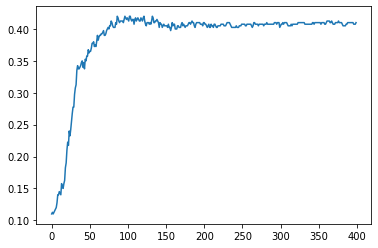

In [28]:
plt.plot(accuracy_array)

In [29]:
max(accuracy_array)

0.42

In [30]:
accuracy_array[-1]

0.41